<a href="https://colab.research.google.com/github/701yq/DL-C-Project/blob/main/Toxic_comment_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_auc_score, f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Download Dataset
## Read Dataset

In [ ]:
!gdown 1Rr06w2Vkpr4ulnjwNLjBXxbfPnuWE9KO

Downloading...
From: https://drive.google.com/uc?id=1Rr06w2Vkpr4ulnjwNLjBXxbfPnuWE9KO
To: /content/train.csv
100% 68.8M/68.8M [00:01<00:00, 49.1MB/s]


In [ ]:
data = pd.read_csv('train.csv')
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


# Preprocessing Data

In [ ]:
data['comment_text'] = data['comment_text'].replace(r'\n', ' ', regex=True).str.strip()
data['comment_text'] = data['comment_text'].replace(r'[^a-zA-Z0-9\s]', '', regex=True).str.strip()
data['comment_text'].head()

,comment_text
0,Explanation Why the edits made under my userna...
1,Daww He matches this background colour Im seem...
2,Hey man Im really not trying to edit war Its j...
3,More I cant make any real suggestions on impro...
4,You sir are my hero Any chance you remember wh...


In [ ]:
from sklearn.model_selection import train_test_split

train_data, temp_data = train_test_split(data, test_size=0.3, random_state=42)

val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")

Training set size: 111699
Validation set size: 23936
Test set size: 23936


# Prepare Feature & Label

In [ ]:
X_train = train_data['comment_text'].fillna("").values
y_train = train_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values

X_val = val_data['comment_text'].fillna("").values
y_val = val_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values

X_test = test_data['comment_text'].fillna("").values
y_test = test_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values

# Tokenization & Padding

In [ ]:
# Tokenize and pad text data
max_words = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)

X_val_seq = tokenizer.texts_to_sequences(X_val)
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len)

X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)


# Build CNN Model

In [ ]:
def build_model(hp):
    model = Sequential()
    model.add(layers.Embedding(input_dim=max_words, output_dim=128, input_length=max_len))

    model.add(layers.Conv1D(
        filters=hp.Int('filters', min_value=32, max_value=128, step=32),
        kernel_size=hp.Int('kernel_size', min_value=3, max_value=7, step=2),
        activation='relu'
    ))

    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dropout(rate=hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(layers.Dense(
        units=hp.Int('dense_units', min_value=32, max_value=128, step=32),
        activation='relu'
    ))

    model.add(layers.Dropout(rate=hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(layers.Dense(6, activation='sigmoid'))

    model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='kt_dir',
    project_name='toxic_comment_random_search'
)


tuner.search(X_train_pad, y_train, epochs=5, batch_size=32, validation_data=(X_val_pad, y_val))

best_model = tuner.get_best_models(num_models=1)[0]

best_model.summary()

Trial 10 Complete [00h 01m 14s]
val_accuracy: 0.9939422011375427

Best val_accuracy So Far: 0.9939422011375427
Total elapsed time: 00h 12m 29s


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 128)            │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 96, 128)             │          82,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 128)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             198 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,366,374 (5.21 MB)

 Trainable params: 1,366,374 (5.21 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]

best_trial_params = best_trial.hyperparameters.values
print(f"Best hyperparameters: {best_trial_params}")

Best hyperparameters: {'filters': 32, 'kernel_size': 5, 'dropout_rate': 0.30000000000000004, 'dense_units': 64, 'learning_rate': 6.028298668163704e-05}


In [ ]:
model = Sequential()
model.add(layers.Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
model.add(layers.Conv1D(filters=32, kernel_size=5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dropout(rate=0.30000000000000004))
model.add(layers.Dense(units=64, activation='relu'))
model.add(layers.Dropout(rate=0.30000000000000004))
model.add(layers.Dense(6, activation='sigmoid'))
model.compile(optimizer=Adam(learning_rate=6.028298668163704e-05), loss='binary_crossentropy', metrics=['accuracy'])

# Train Model

In [ ]:
history = model.fit(X_train_pad, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Epoch 1/10
2793/2793 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.4962 - loss: 0.3070 - val_accuracy: 0.9938 - val_loss: 0.1267
Epoch 2/10
2793/2793 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.7189 - loss: 0.1204 - val_accuracy: 0.9941 - val_loss: 0.0715
Epoch 3/10
2793/2793 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.8626 - loss: 0.0752 - val_accuracy: 0.9941 - val_loss: 0.0601
Epoch 4/10
2793/2793 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9171 - loss: 0.0645 - val_accuracy: 0.9941 - val_loss: 0.0570
Epoch 5/10
2793/2793 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9511 - loss: 0.0592 - val_accuracy: 0.9941 - val_loss: 0.0557
Epoch 6/10
2793/2793 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9674 - loss: 0.0562 - val_accuracy: 0.9941 - val_loss: 0.0551
Epoch 7/10
2793/2793 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9733 - loss: 0.0537 - val_accuracy: 0.9941 - val_loss: 0.0551
Epoch 8/10
2793/2793 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9848 - loss: 0.052

# Evaluate Model

In [ ]:
y_val_pred = best_model.predict(X_val_pad)

roc_auc_scores = {}
for i, label in enumerate(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']):
    roc_auc_scores[label] = roc_auc_score(y_val[:, i], y_val_pred[:, i])

print("\nROC AUC scores for each label:")
for label, score in roc_auc_scores.items():
    print(f"{label}: {score:.4f}")

avg_roc_auc = sum(roc_auc_scores.values()) / len(roc_auc_scores)
print(f"\nAverage ROC AUC Score: {avg_roc_auc:.4f}")

748/748 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

ROC AUC scores for each label:
toxic: 0.9643
severe_toxic: 0.9840
obscene: 0.9853
threat: 0.9472
insult: 0.9738
identity_hate: 0.9478

Average ROC AUC Score: 0.9671


# Prediction Function

In [ ]:
def predict_toxicity(text, threshold=0.5):
    # Tokenize and pad the text
    text_seq = tokenizer.texts_to_sequences([text])
    text_pad = pad_sequences(text_seq, maxlen=max_len)

    pred = model.predict(text_pad)[0]

    labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

    result = {label: round(score, 4) for label, score in zip(labels, pred)}


    highest_score_label = labels[np.argmax(pred)]
    highest_score = np.max(pred)

    if highest_score < threshold:
        result["overall"] = "Non-toxic"
    else:
        result["overall"] = highest_score_label

    return result

In [ ]:
text_input = "Fuck you bitch, Everything you say is garbage, and no one can stand you."
print(predict_toxicity(text_input))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
{'toxic': 0.9958, 'severe_toxic': 0.4398, 'obscene': 0.9808, 'threat': 0.0389, 'insult': 0.8891, 'identity_hate': 0.1605, 'overall': 'toxic'}


In [ ]:
text_input = "you pissing me off you suckass stop blabbering can you"
print(predict_toxicity(text_input))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
{'toxic': 0.8975, 'severe_toxic': 0.1801, 'obscene': 0.5393, 'threat': 0.1351, 'insult': 0.5052, 'identity_hate': 0.1885, 'overall': 'toxic'}


In [ ]:
text_input = "it seems today was pretty good day for me, do you want some gaming session later tonight?"
print(predict_toxicity(text_input))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
{'toxic': 0.0009, 'severe_toxic': 0.0, 'obscene': 0.0, 'threat': 0.0, 'insult': 0.0, 'identity_hate': 0.0, 'overall': 'Non-toxic'}


# Visualization

## Distribution Comment Categories

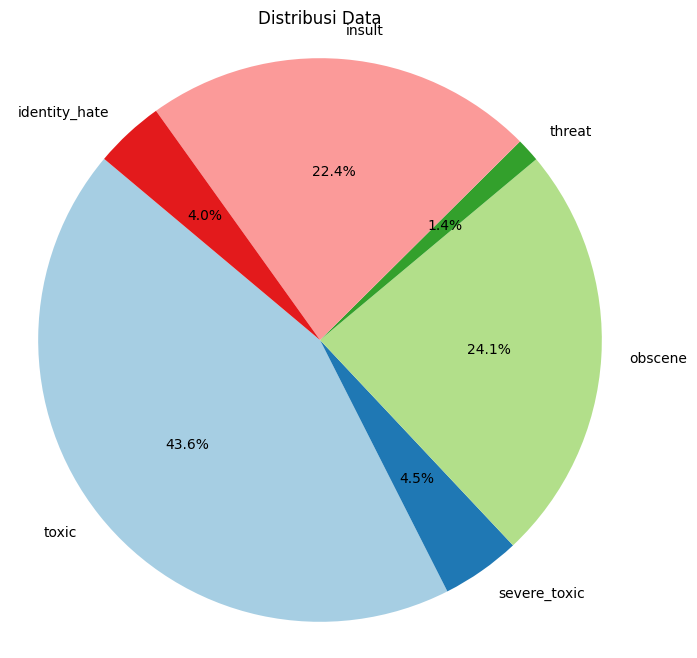

In [ ]:
# Get the sum of each label from the training data
category_counts = data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum()

plt.figure(figsize=(8, 8))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title("Distribusi Data")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Display the chart
plt.show()

## Distribution Comment Multilabel

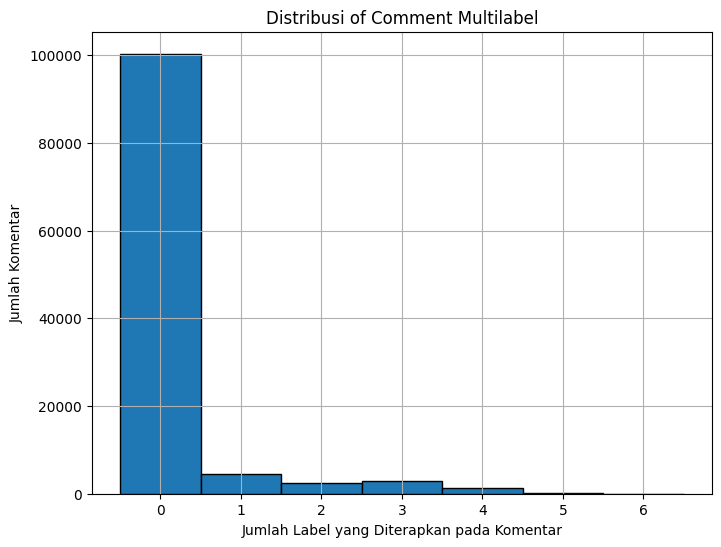

In [ ]:
# Menghitung jumlah label yang relevan untuk setiap komentar (jumlah nilai 1 per baris)
multilabel_counts = train_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(axis=1)

# Membuat histogram untuk mendeteksi multilabel
plt.figure(figsize=(8, 6))
plt.hist(multilabel_counts, bins=range(0, 8), edgecolor='black', align='left')
plt.xlabel('Jumlah Label yang Diterapkan pada Komentar')
plt.ylabel('Jumlah Komentar')
plt.title('Distribusi of Comment Multilabel')
plt.xticks(range(0, 7))  # Menambahkan label x-axis untuk 0 hingga 6 label
plt.grid(True)
plt.show()

## Distribution Comment Lengths

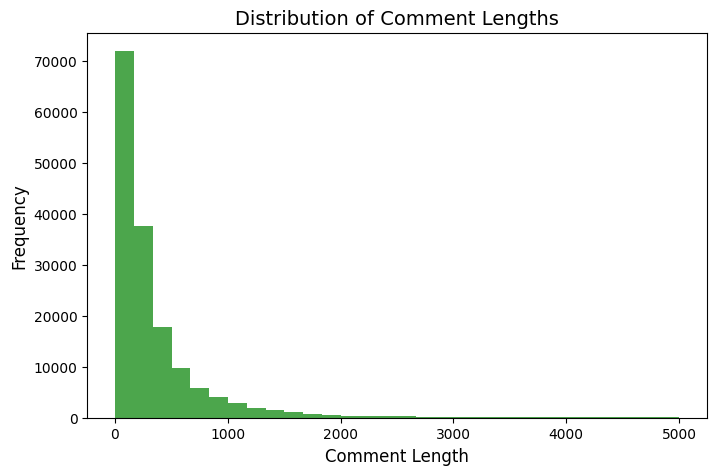

In [ ]:
# Distribusi Panjang Teks Visualisasi

# Calculate text lengths
text_lengths = data['comment_text'].apply(len)

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(text_lengths, bins=30, color="green", alpha=0.7)
plt.title("Distribution of Comment Lengths", fontsize=14)
plt.xlabel("Comment Length", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show()


## Wordcloud Categories

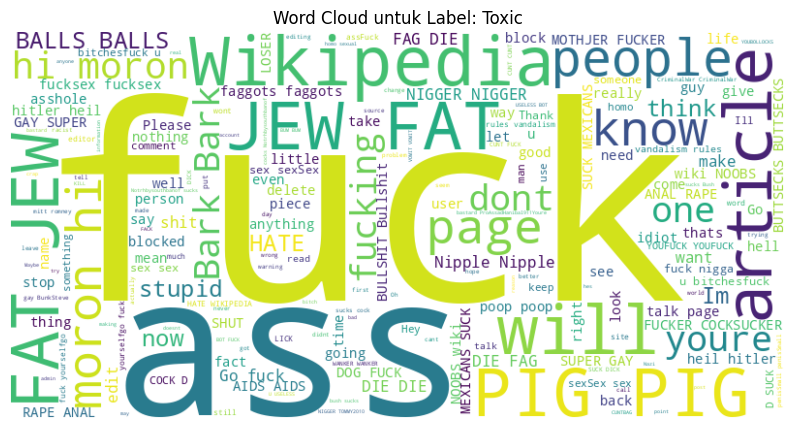

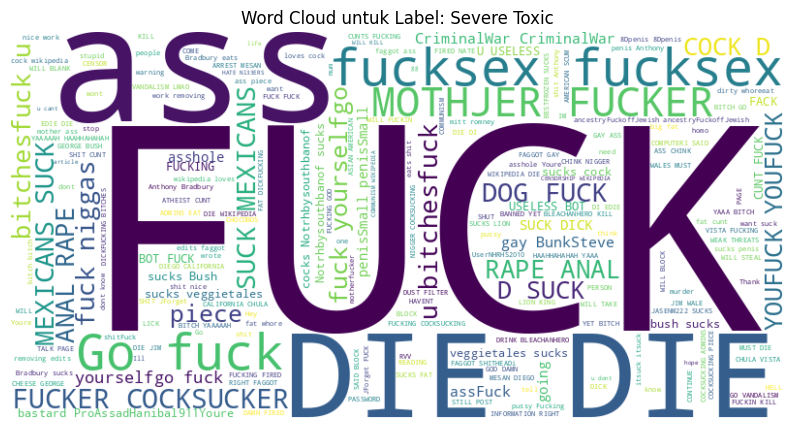

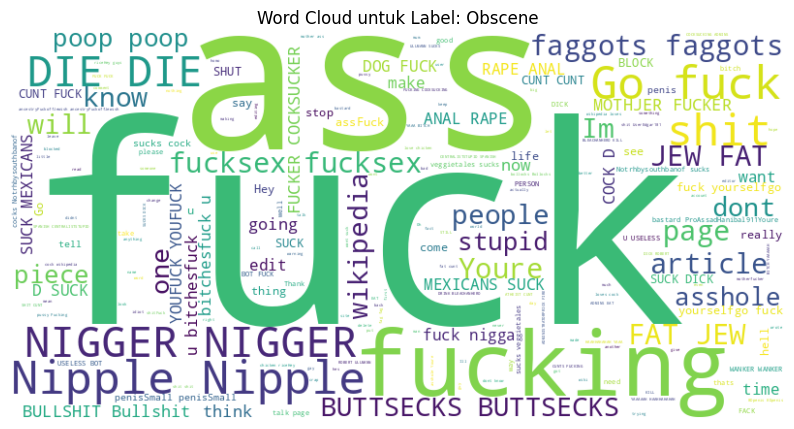

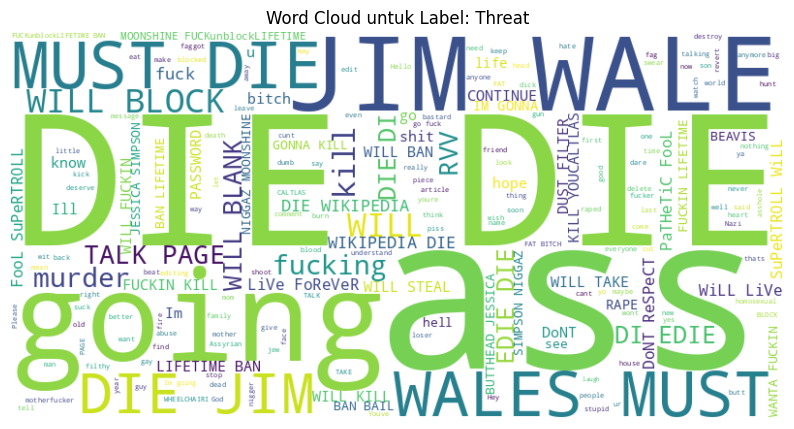

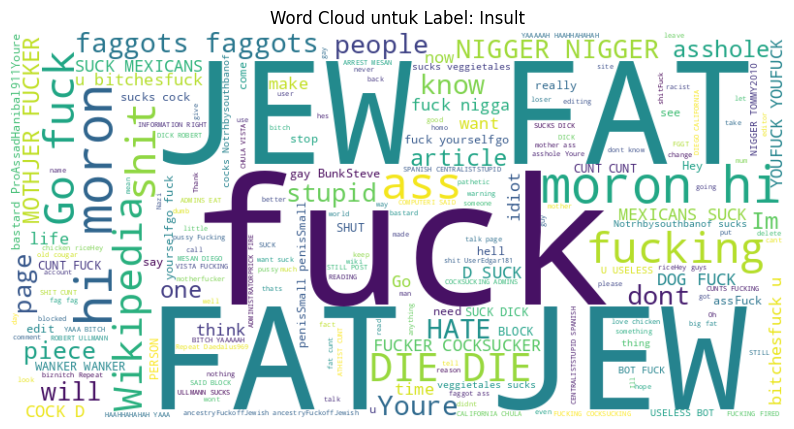

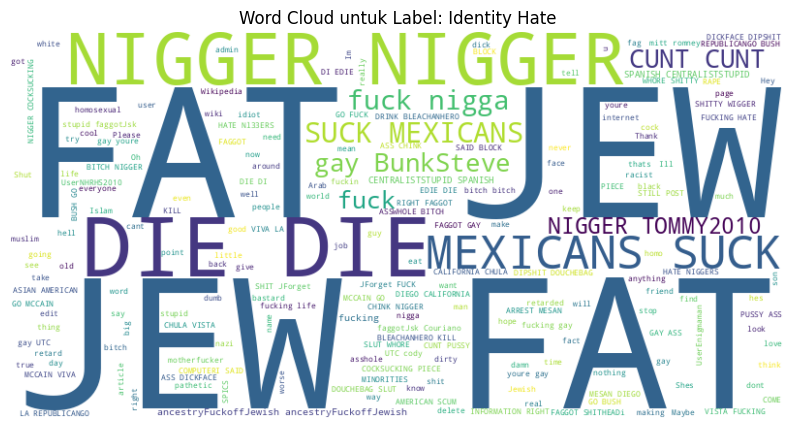

In [ ]:
from wordcloud import WordCloud

# Fungsi untuk menghasilkan word cloud berdasarkan label tertentu
def generate_wordcloud(data, label, label_name):
    # Ambil semua komentar yang memiliki label 1
    text = data[data[label] == 1]['comment_text'].str.cat(sep=' ')

    # Buat word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    # Plotting word cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud untuk Label: {label_name}')

    # Simpan gambar ke file terpisah
    plt.savefig(f'wordcloud_{label_name}.png', bbox_inches='tight')
    plt.show()

# Membuat word cloud untuk setiap label
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
label_names = ['Toxic', 'Severe Toxic', 'Obscene', 'Threat', 'Insult', 'Identity Hate']

for label, label_name in zip(labels, label_names):
    generate_wordcloud(train_data, label, label_name)

## Distribution Heatmap Corelation Label

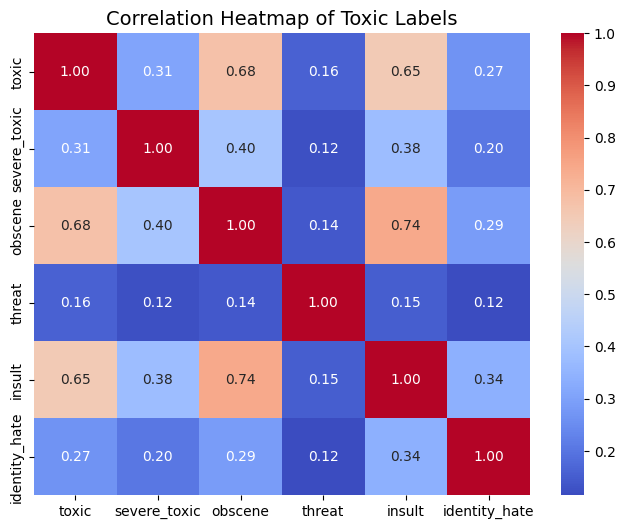

In [ ]:
# Heatmap Korelasi Label
# Compute correlation matrix
correlation_matrix = data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Toxic Labels", fontsize=14)
plt.show()


## Distribution Validation Accuracy & Loss


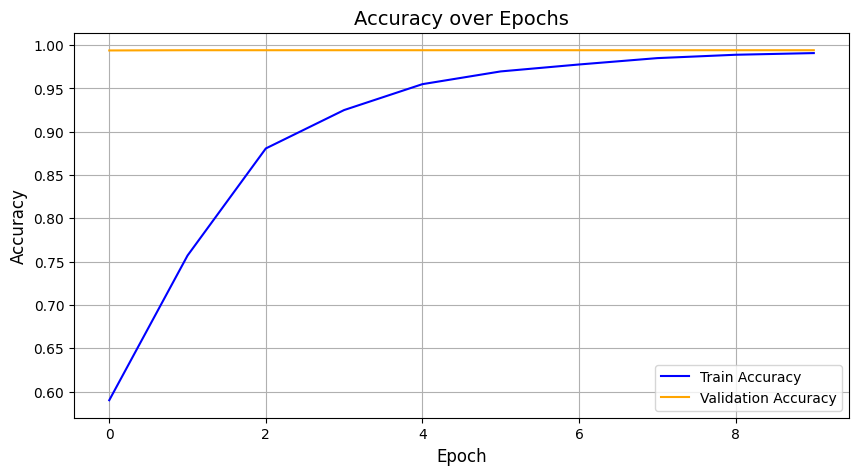

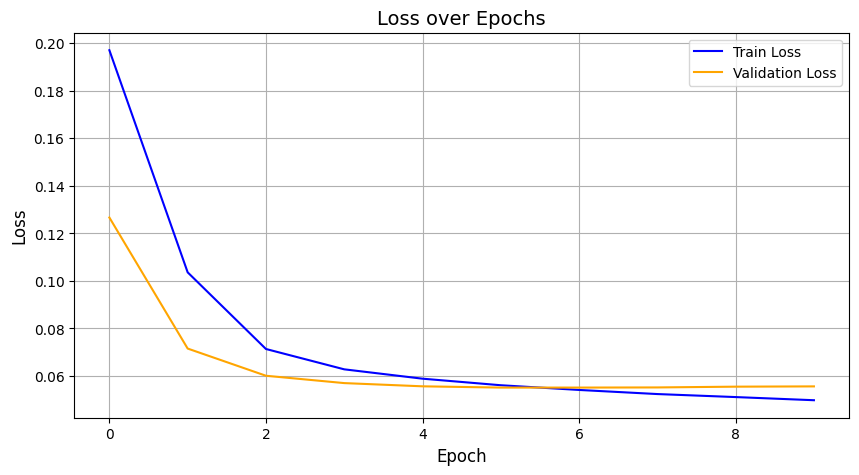

In [ ]:
# Performa Training Visualisasi
# Plot training and validation accuracy
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title("Accuracy over Epochs", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title("Loss over Epochs", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()



## ROC-AUC


<ipython-input-23-8f5c119d22fc>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=scores, palette="Blues_d")


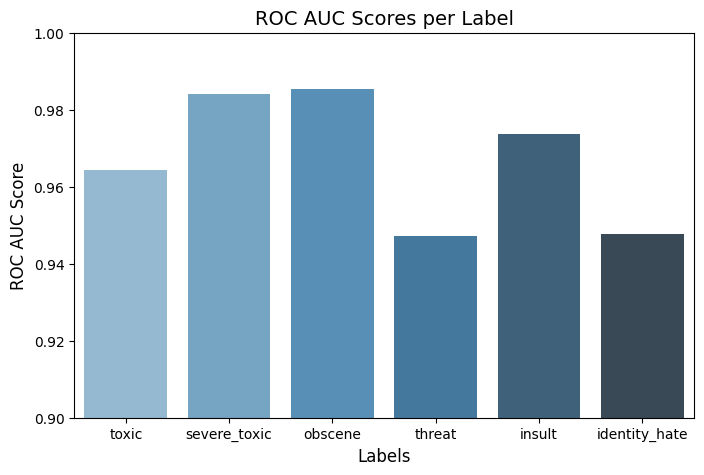

In [ ]:
# AUC-ROC Visualisasi


# Data untuk ROC AUC Score
labels = list(roc_auc_scores.keys())
scores = list(roc_auc_scores.values())

# Bar Plot
plt.figure(figsize=(8, 5))
sns.barplot(x=labels, y=scores, palette="Blues_d")
plt.title("ROC AUC Scores per Label", fontsize=14)
plt.ylabel("ROC AUC Score", fontsize=12)
plt.xlabel("Labels", fontsize=12)
plt.ylim(0.9, 1.0)
plt.show()



## Confusion Matrix

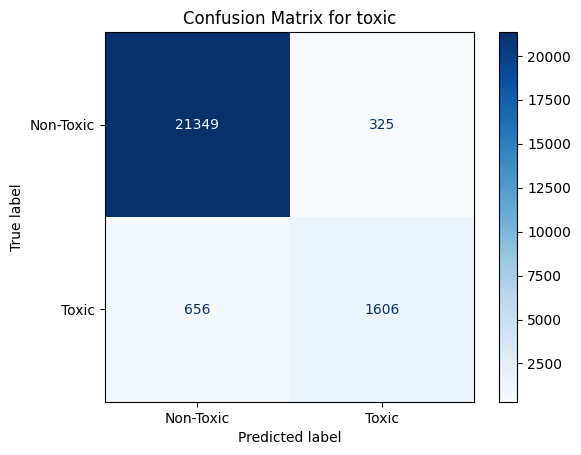

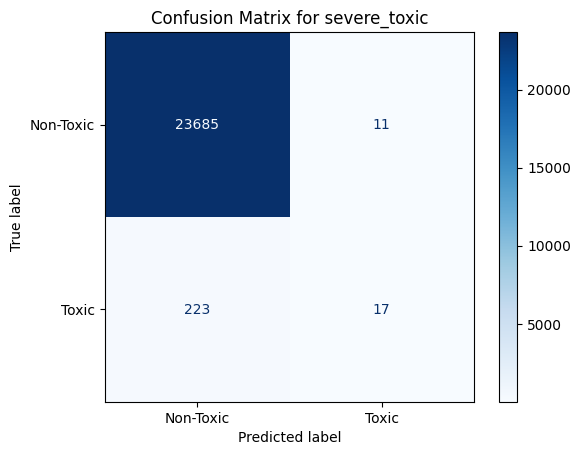

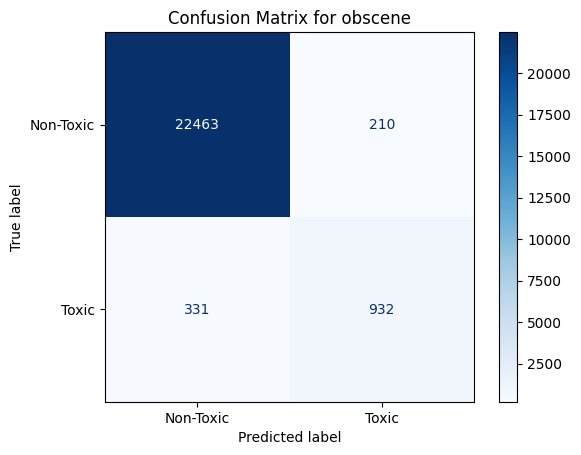

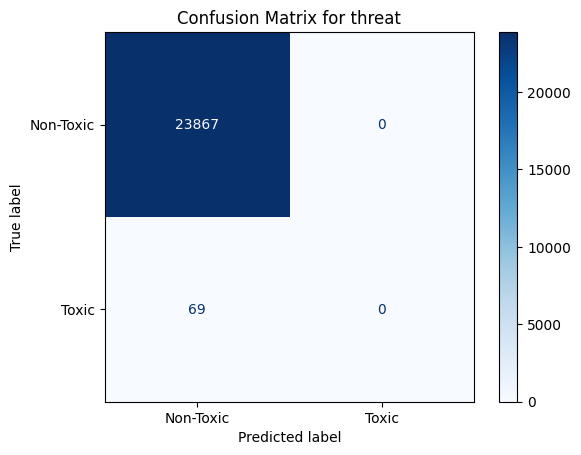

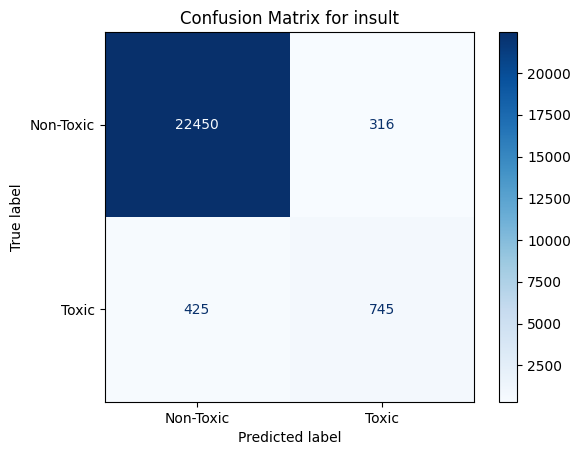

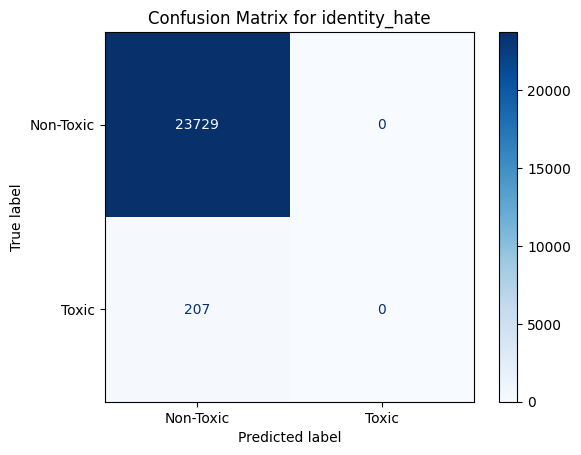

In [ ]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Convert probabilities to binary predictions
threshold = 0.5
y_val_pred_binary = (y_val_pred >= threshold).astype(int)

# Confusion matrix for each label
for i, label in enumerate(labels):
    cm = confusion_matrix(y_val[:, i], y_val_pred_binary[:, i])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Toxic", "Toxic"])
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix for {label}")
    plt.show()
